In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
import numpy as np

2021-09-26 06:56:00.425632: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [55]:
#######################
embedding_dim = 300
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 1280000
#######################

In [4]:
df = pd.read_csv("../input/training1600000processednoemoticoncsv/training.1600000.processed.noemoticon.csv",
                encoding = "latin" , names = ['sentiment', 'id', 'date', 'query', 'user_id', 'text'])
df.head()


,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.drop(columns = ['id', 'date', 'query', 'user_id'] , inplace = True)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:

df["sentiment"] = [0 if value == 0 else 1 for value in df["sentiment"]]


In [7]:
#data_split


training_sentences = df.loc[:training_size,"text"]
training_labels = df.loc[:training_size,"sentiment"]

test_sentences = df.loc[training_size:,"text"]
test_labels = df.loc[training_size:,"sentiment"]


In [8]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>",
                      filters = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [56]:
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 374642


In [9]:
train_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(train_sequences, padding = "post" , maxlen = max_length,
                               truncating = trunc_type)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences,padding = "post", maxlen = max_length,
                           truncating = trunc_type)

In [10]:
training_padded[0]

array([  22,    6,  572,  113,   22,    1,   16, 1871,   43, 2889,   23,
        171,   33,    9,  443,    6,  551,   29, 1594,    9,    7,    4,
         65,    2,   18, 1424,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [31]:
GLOVE_EMB = '../input/glove6b300dtxt/glove.6B.300d.txt'

embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [51]:
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [57]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [59]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=max_length,
                                          trainable=False)

In [60]:
#model
model = tf.keras.Sequential([
    embedding_layer, #calculating vector word by word
    tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)), 
    tf.keras.layers.Dense(512, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          112392600 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 112,646,041
Trainable params: 253,441
Non-trainable params: 112,392,600
_________________________________________________________________


In [61]:
model.compile(loss = "binary_crossentropy",optimizer = "adam",metrics = ["accuracy"])

In [63]:
num_epochs = 10
history = model.fit(training_padded , training_labels , epochs = num_epochs  ,
                    batch_size = 1024*2,validation_data = (test_padded,test_labels))


Epoch 1/10
626/626 [==============================] - 498s 795ms/step - loss: 0.5411 - accuracy: 0.7250 - val_loss: 1.0767 - val_accuracy: 0.4166
Epoch 2/10
626/626 [==============================] - 495s 790ms/step - loss: 0.5039 - accuracy: 0.7517 - val_loss: 1.7253 - val_accuracy: 0.1829
Epoch 3/10
626/626 [==============================] - 493s 788ms/step - loss: 0.4998 - accuracy: 0.7539 - val_loss: 0.6358 - val_accuracy: 0.6476
Epoch 4/10
626/626 [==============================] - 492s 786ms/step - loss: 0.4830 - accuracy: 0.7647 - val_loss: 0.2854 - val_accuracy: 0.8938
Epoch 5/10
626/626 [==============================] - 492s 786ms/step - loss: 0.4823 - accuracy: 0.7655 - val_loss: 0.5298 - val_accuracy: 0.7417
Epoch 6/10
626/626 [==============================] - 491s 785ms/step - loss: 0.4739 - accuracy: 0.7709 - val_loss: 0.8909 - val_accuracy: 0.5284
Epoch 7/10
626/626 [==============================] - 492s 787ms/step - loss: 0.4688 - accuracy: 0.7737 - val_loss: 0.7402 -

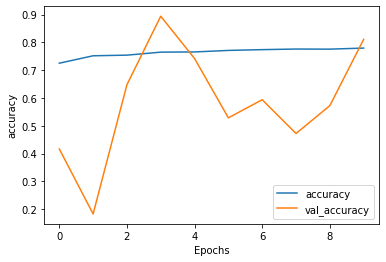

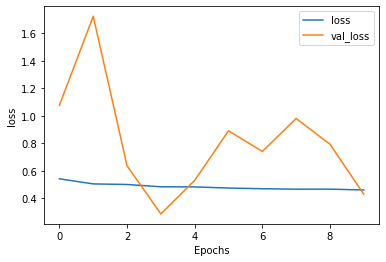

In [64]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")